# **TEAM 15**
*   Adria Caelles
*   Sandeep John V
*   Oscar Pina
*   Lucas Ventura



---
# **Exercise 1:  Convolutional Autoencoder**
---
Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images


## Importing libraries and packages



In [0]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from timeit import default_timer as timer

# For table
from prettytable import PrettyTable

# For loaders
import random
from random import shuffle

# For deepcopy
import copy

# To print table
import plotly.graph_objects as go

# To split training data to train and validation. Uses SubsetRandomSampler to shuffle indices
from torch.utils.data.sampler import SubsetRandomSampler 

## Setup

In [2]:
# Random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(SEED)

print(f"Device running on {device}")

Device running on cuda


In [0]:
# Let's define some hyper-parameters
hparams = {
    'bottleneck_size': 10,
    'batch_size':64,
    'num_epochs':20,
    'test_batch_size':64,
    'learning_rate':1e-3,
    'valid_size': 0.05, # percentage split of the training set used for the validation set.
    'device': device
}

## Loading data

Note: The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

In [0]:
mnist_mean = 0.1307
mnist_std = 0.3081

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((mnist_mean-mnist_std,), (2*mnist_std,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((mnist_mean-mnist_std,), (2*mnist_std,))
                               ]))

Split the original training data into 95% training and 5% validation data.

In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(np.floor(hparams['valid_size'] * num_train))

if shuffle == True:
  np.random.seed(random_seed)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## Visualize the Data

Now let's take a look at some examples. We'll use the test_loader for this.

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Ok let's see what one test data batch consists of.

In [7]:
example_data.shape

torch.Size([64, 1, 28, 28])

So one test data batch is a  tensor of shape: Vector(4) [64, 1, 28,28]. This means we have *test_batch_size* examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.


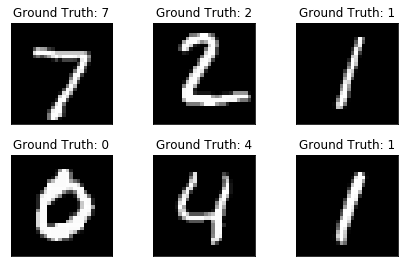

In [8]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([]) # No ticks in x axis
  plt.yticks([]) # No ticks in y axis

## Encoder
Input data is passed through an encoder
Input images are 28x28x1 in size. These images will be passed through encoder layers

Encoder will compress the input.

It will have convolutional layers followed by max pooling layer to reduce dimensions to 7x7x4


**Note:**

> *nn.Conv2d(in_channels, out_channels/number of filters (k), kernel_size (K), stride (S) = 1, padding (P) = 0)*

> Input volume size  W1 x W1 x D1

> Output volume size W2 x W2 x D2

> W2 = (W1 - F + 2P) / S + 1

> D2 = K

**Note2:**


> If there is any situation that you don't know how many columns you want but are sure of the number of rows, then you can specify view with a -1 (Only one of the axis value can be -1). This is a way of telling the library: "give me a tensor that has these many rows and you compute the appropriate number of columns that is necessary to make this happen".



In [9]:
class ConvEncoder(nn.Module):
  def __init__(self, bottleneck=10):
    super().__init__()
    
    self.convEncoder = nn.Sequential(
        # conv layer (depth from 1 --> 32), 3x3 kernels
        nn.Conv2d(1, 32, 3,  padding=1),  # 28 x 28 x 32
        nn.ReLU(True),
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        nn.MaxPool2d(2, stride=2),  # 14 x 14 x 32
        
        # conv layer (depth from 32 --> 64), 3x3 kernels
        nn.Conv2d(32, 64, 3, padding=1),  # 14 x 14 x 64
        nn.ReLU(True),
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        nn.MaxPool2d(2, 2),  # 7 x 7 x 64

        nn.Conv2d(64, 128, 3, padding=1),  # 7 x 7 x 128
        nn.ReLU(True),
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        nn.MaxPool2d(2, 2) # 3 x 3 x 128
    )

    self.mlpEncoder = nn.Sequential(
        nn.Linear(3*3*128, bottleneck),
        nn.ReLU()
    )
    
  def forward(self, x):
    x = self.convEncoder(x)
    x = x.view(x.shape[0], -1) # Flatten
    x = self.mlpEncoder(x)
    return x

# Print model
print(ConvEncoder())

ConvEncoder(
  (convEncoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlpEncoder): Sequential(
    (0): Linear(in_features=1152, out_features=10, bias=True)
    (1): ReLU()
  )
)


## Decoder
Compressed data is is passed through a decoder to reconstruct the input data

This layer will bring back to original dimension 28x28x1

Will use transposed convolutional layers to increase width and height of compressed input

**ConvTranspose2d:**


>  ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')


**Formula:**


> W_out = (W_in - 1)*stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1





In [10]:
class ConvDecoder(nn.Module):
  def __init__(self, bottleneck=10):
    super().__init__()
    
    self.mlpDecoder = nn.Sequential(
        nn.Linear(bottleneck, 2*2*64),
        nn.ReLU()
    )

    self.conDecoder = nn.Sequential(
        # 5 = (2-1)*2 - 2*0 + 1*(3-1) + 0 + 1 
        nn.ConvTranspose2d(64, 32, 3, stride=2),  # 5 x 5 x 32
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),  # 15 x 15 x 16
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),  # 28 x 28 x 1
        nn.Sigmoid()
    )
          
  def forward(self, x):
    x = self.mlpDecoder(x)
    x = x.view(x.shape[0], 64, 2, 2) # Linear vector to 2 x 2 x 64
    x = self.conDecoder(x)      
    return x

# Print decoder
print(ConvDecoder())

ConvDecoder(
  (mlpDecoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
  )
  (conDecoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


## Convolutional Autoencoder
We merge encoder and decoder in a single class (ConvolutionalAutoencoder)

In [0]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, bottleneck= 10):
        super().__init__()

        self.encoder = ConvEncoder(bottleneck)
        self.decoder = ConvDecoder(bottleneck)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)

        return reconstruction

## Train


In [0]:
def validate_epoch(valid_loader, network, criterion):
  network.eval()

  valid_loss = 0.0

  with torch.no_grad():
    for data in valid_loader:
      images, _ = data
      images = images.to(device)

      outputs = network(images)               # forward pass: compute predicted outputs
      loss = criterion(outputs, images)       # calculate the loss
      
      valid_loss += loss.item()
  
  return valid_loss/len(valid_loader)

In [0]:
def train_network(train_loader, valid_loader, network, optimizer, criterion):
  # Activate the train=True flag inside the model
  network.train()
  train_loss_record= []
  validation_loss_record= []

  for epoch in range(1, hparams['num_epochs'] + 1):
    train_loss = 0.0                          # monitor training loss
    for data in train_loader:
      images, _ = data                        # Intrested in just the images
      # no need to flatten images
      images = images.to(device)
      optimizer.zero_grad()                   # clear the gradients
      outputs = network(images)               # forward pass: compute predicted outputs 
      loss = criterion(outputs, images)       # calculate the loss
      loss.backward()                         # backward pass
      optimizer.step()                        # perform optimization step
      train_loss_record.append(loss.item())
      train_loss += loss.item()               # update running training loss

    #Overall loss or loss average of train images
    val_loss = validate_epoch(valid_loader, network, criterion)
    validation_loss_record.append(val_loss)

    print(f"Train loss \t{epoch}: {train_loss/len(train_loader)}")
    print(f"Validation loss {epoch}: {val_loss}")

  return train_loss_record, validation_loss_record


In [14]:
model = ConvolutionalAutoencoder(hparams['bottleneck_size']).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'],
                             weight_decay=1e-5)

train_loss, validation_loss = train_network(train_loader, valid_loader, model, optimizer, criterion)

Train loss 	1: 0.14268401468342
Validation loss 1: 0.12982144507955998
Train loss 	2: 0.12743418714748622
Validation loss 2: 0.12403533179709252
Train loss 	3: 0.12417059655977553
Validation loss 3: 0.12185962894495497
Train loss 	4: 0.12238100870155993
Validation loss 4: 0.12073999215313728
Train loss 	5: 0.12103507400194537
Validation loss 5: 0.1191927673334771
Train loss 	6: 0.11997206257415807
Validation loss 6: 0.11893658450943359
Train loss 	7: 0.11891146798594097
Validation loss 7: 0.1173446590596057
Train loss 	8: 0.11812087889305001
Validation loss 8: 0.11713177425430175
Train loss 	9: 0.11743428160914134
Validation loss 9: 0.11643040465547684
Train loss 	10: 0.11615247634792435
Validation loss 10: 0.11396601970525498
Train loss 	11: 0.11327784053571564
Validation loss 11: 0.11187244032291656
Train loss 	12: 0.11189674593583503
Validation loss 12: 0.11069307397020624
Train loss 	13: 0.11094151866255385
Validation loss 13: 0.11015951522487274
Train loss 	14: 0.11038570344347745

In [15]:
print(f"Validation length: {len(train_loss)}")
print(f"Validation length: {len(validation_loss)}")

Validation length: 17820
Validation length: 20


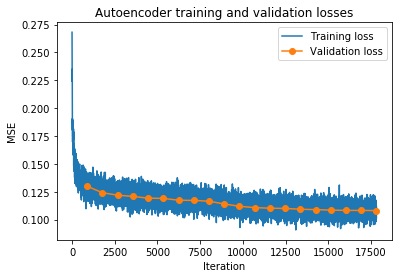

In [16]:
plt.title('Autoencoder training and validation losses')
plt.plot(train_loss, label='Training loss')
plt.plot(np.linspace(len(train_loss)/len(validation_loss), len(train_loss), len(validation_loss)), validation_loss, '-o', label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend();

## Comparing inputs before encoding and output after decoding
Below we can notice that ouput edges are not smooth like in inputs. This is due to checkerboard effect that will happen with transpose layers


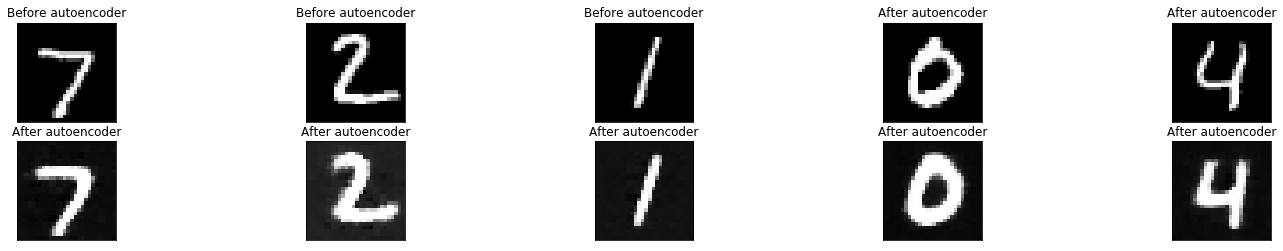

In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Test in device
model.eval()
model.cpu()

output = model(images)                                      # get sample outputs
images = images.numpy()                                     # prep images for display
output = output.view(hparams['test_batch_size'], 1, 28, 28) # resizing output
output = output.detach().numpy()                            # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
i=0
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        if(i<3):
          ax.set_title('Before autoencoder')
        else:
          ax.set_title('After autoencoder')
          
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        i+=1
        






## Train the convolutional autoencoder, with different bottleneck sizes.

Done for 5, 10 and 50

In [18]:
bottleneck_sizes = [5, 10, 50]
bottleneck_autoencoders = {}

for bottleneck_size in bottleneck_sizes:

    bottleneck_model = ConvolutionalAutoencoder(bottleneck_size).to(device)

    # Loss function
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(bottleneck_model.parameters(), lr=hparams['learning_rate'],
                                weight_decay=1e-5)
    
    num_parameters = sum([p.numel() for p in bottleneck_model.parameters() if p.requires_grad]) 

    train_loss = []
    validation_loss = []
    
    print('-' * 40)
    print(f"Bottleneck size = {bottleneck_size}")
    print('-' * 40)
    train_loss, validation_loss = train_network(train_loader, valid_loader, bottleneck_model, optimizer, criterion)

    # Compute the MSE per image on the train, validation and test sets.
    train_error = validate_epoch(train_loader, bottleneck_model, criterion)
    validation_error = validate_epoch(valid_loader, bottleneck_model, criterion)
    test_error = validate_epoch(test_loader, bottleneck_model, criterion)

    bottleneck_autoencoders[bottleneck_size] = {"train_loss": train_loss, "validation_loss": validation_loss, "num_parameters": num_parameters, "train_error": train_error, "validation_error": validation_error, "test_error": test_error}

----------------------------------------
Bottleneck size = 5
----------------------------------------
Train loss 	1: 0.15774890243605733
Validation loss 1: 0.14911185648847133
Train loss 	2: 0.14756060456888442
Validation loss 2: 0.14025525970661895
Train loss 	3: 0.1370029855105612
Validation loss 3: 0.1344318117233033
Train loss 	4: 0.13388946240999883
Validation loss 4: 0.1325454868851824
Train loss 	5: 0.13224362110349064
Validation loss 5: 0.13114298959361745
Train loss 	6: 0.13084171865423921
Validation loss 6: 0.12956590887079847
Train loss 	7: 0.12937684195778854
Validation loss 7: 0.12795606683543387
Train loss 	8: 0.12338084133820636
Validation loss 8: 0.11993255054062986
Train loss 	9: 0.1195004463245973
Validation loss 9: 0.11812405906459118
Train loss 	10: 0.1180937450910123
Validation loss 10: 0.116844764098208
Train loss 	11: 0.11720031065872623
Validation loss 11: 0.11660591782407558
Train loss 	12: 0.11652370931122841
Validation loss 12: 0.11573290460287257
Train loss 

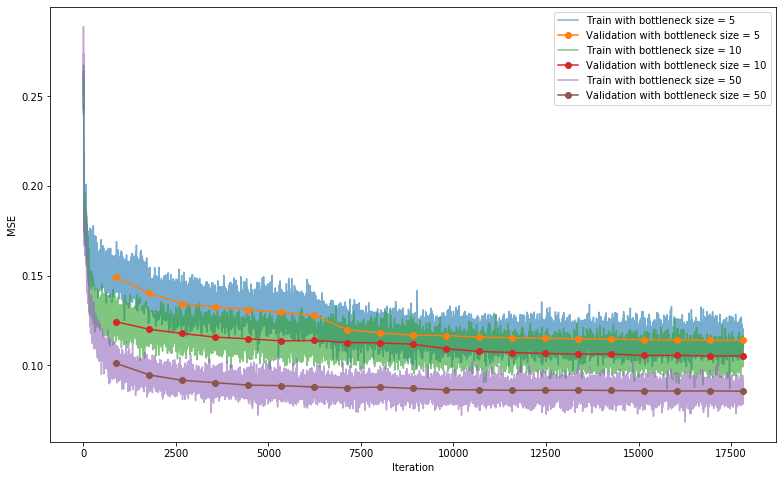

In [19]:
plt.figure(figsize=(13,8))

for bottleneck_size in bottleneck_autoencoders:

  bottleneck_train_loss = bottleneck_autoencoders[bottleneck_size]["train_loss"]
  bottleneck_validation_loss = bottleneck_autoencoders[bottleneck_size]["validation_loss"]

  plt.plot(bottleneck_train_loss, '-', label=f"Train with bottleneck size = {bottleneck_size}", alpha=0.6)
  plt.plot(np.linspace(len(bottleneck_train_loss)/len(bottleneck_validation_loss), len(bottleneck_train_loss), len(bottleneck_validation_loss)), 
           bottleneck_validation_loss, '-o', label = f"Validation with bottleneck size = {bottleneck_size}",
           zorder=10) # zorder puts Validation on top in plot


plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.show()

## Image reconstruction error on the test set.

In [77]:
table = PrettyTable()
table.field_names = ['Bottleneck size','Train error', 'Validation error', 'Test error', 'Num parameters']

for bottleneck_size in bottleneck_sizes:
  train_errors  = round(bottleneck_autoencoders[bottleneck_size]["train_error"], 3)
  validation_errors = round(bottleneck_autoencoders[bottleneck_size]["validation_error"], 3)
  test_errors = round(bottleneck_autoencoders[bottleneck_size]["test_error"], 3)
  num_params = bottleneck_autoencoders[bottleneck_size]["num_parameters"]

  table.add_row([bottleneck_size, train_errors, validation_errors, test_errors, num_params])


print(table)

+-----------------+-------------+------------------+------------+----------------+
| Bottleneck size | Train error | Validation error | Test error | Num parameters |
+-----------------+-------------+------------------+------------+----------------+
|        5        |    0.114    |      0.114       |   0.116    |     131318     |
|        10       |    0.105    |      0.105       |   0.107    |     138363     |
|        50       |    0.085    |      0.086       |   0.087    |     194723     |
+-----------------+-------------+------------------+------------+----------------+


In [20]:
train_errors= []
validation_errors= []
test_errors=[]
num_params= []



for bottleneck_size in bottleneck_sizes:
  train_errors.append(round(bottleneck_autoencoders[bottleneck_size]["train_error"], 3))
  validation_errors.append(round(bottleneck_autoencoders[bottleneck_size]["validation_error"], 3))
  test_errors.append(round(bottleneck_autoencoders[bottleneck_size]["test_error"], 3))
  num_params.append(bottleneck_autoencoders[bottleneck_size]["num_parameters"])

fig = go.Figure(data=[go.Table(header=dict(values=['Bottleneck size','Train error', 'Validation error', 'Test error', 'Num parameters']),
                               cells=dict(values=[bottleneck_sizes, train_errors, validation_errors, test_errors, num_params]))])

fig.show()


## Generate 6 new images by injecting random values as input to the decoder.




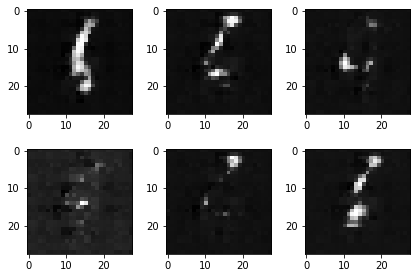

In [21]:
inputs = 5*torch.rand(6, hparams['bottleneck_size'])

model.eval()
model.cpu()

output = model.decoder(inputs)
output = output.detach().numpy()  

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(output[i][0], cmap='gray', interpolation='none')

---

# **Exercise 2:  Transfer Learning**

---







## Subset of 100 images from MNIST dataset


In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))

if shuffle == True:
  np.random.seed(random_seed)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[:100], indices[5000:10000]

train_sampler_classifier = SubsetRandomSampler(train_idx)
valid_sampler_classifier = SubsetRandomSampler(valid_idx)

train_loader_classifier = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=train_sampler_classifier)

valid_loader_classifier = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=valid_sampler_classifier)

In [0]:
class ConvClassifier(nn.Module):
  def __init__(self, encoder, mlp_input_size, dropout=0):
    super().__init__()
    self.encoder = encoder
    self.dropout = nn.Dropout(dropout)
    self.mlp = nn.Sequential(
        nn.Linear(mlp_input_size, 30),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(30, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.LogSoftmax(dim = 1)
    )
  def forward(self,x):
    x = self.encoder(x)
    x = x.view(x.shape[0], -1)
    x = self.dropout(x)
    x = self.mlp(x)
    return x

In [0]:
class AverageMeter(object):
    #Computes and stores the average and current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch_classifier(train_loader, classifier, optimizer, criterion, epoch, hparams):
  # Activate the train=True flag inside the model
  classifier.train()
  device = hparams['device']

  train_loss = AverageMeter()
  train_acc  = AverageMeter()

  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = classifier(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      train_loss.update(loss.item(), n=len(target))
      pred = output.round()  # get the prediction
      acc = correct_predictions(pred,target)/len(target)
      train_acc.update(acc, n=len(target))

  return train_loss.avg,train_acc.avg

def valid_epoch_classifier(valid_loader, classifier, criterion, hparams):
    classifier.eval()
    device = hparams['device']

    valid_loss = AverageMeter()
    valid_acc  = AverageMeter()

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            loss = criterion(output,target)

            valid_loss.update(loss.item(), n=len(target))
            pred = output.round()  # get the prediction
            acc = correct_predictions(pred,target)/len(target)
            valid_acc.update(acc, n=len(target))


    return valid_loss.avg, valid_acc.avg

In [0]:
def plot_train_classifier_results(tr_losses, tr_accs, val_losses, val_accs):
  plt.figure(figsize=(10, 8))
  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('NLLLoss')
  plt.plot(tr_losses, label='train')
  plt.plot(val_losses, label='validation')
  plt.legend()
  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(tr_accs, label='train')
  plt.plot(val_accs, label='validation')
  plt.legend()


In [0]:
def train_classifier(epochs, train_loader, valid_loader, classifier, optimizer, criterion, hparams):
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []

  for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_epoch_classifier(train_loader, classifier, optimizer, criterion, epoch, hparams)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = valid_epoch_classifier(valid_loader, classifier, criterion, hparams)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print('[TRAIN] epoch {} : Loss {}, Accuracy {}.'.format(epoch, train_loss, round(100*train_acc)))
    print('[VAL] \tepoch {} : Loss {}, Accuracy {}.'.format(epoch, val_loss, round(100*val_acc)))
  
  plot_train_classifier_results(train_losses, train_accs, val_losses, val_accs)
  return train_losses, val_losses


In [0]:
def test_classifier(test_loader, classifier):
    classifier.eval()
    device = hparams['device']
    test_acc  = AverageMeter()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            pred = output.round()  # get the prediction
            acc = correct_predictions(pred,target)/len(target)
            test_acc.update(acc, n=len(target))


    return test_acc.avg


In [0]:
epochs = 50
dropout=0.5

**Transfer Learning:**

**Pre-training:**

In [0]:
feature_extractor = copy.deepcopy(model.encoder.convEncoder)

feature_extractor.to(hparams['device'])

classifier_pt = ConvClassifier(feature_extractor, 3*3*128, dropout)

In [0]:
optimizer_classifier_pt = optim.Adam(classifier_pt.to(hparams['device']).parameters(), lr=1e-3)
criterion_classifier_pt = F.nll_loss

[TRAIN] epoch 1 : Loss 2.348032569885254, Accuracy 11.
[VAL] 	epoch 1 : Loss 2.2938274505615235, Accuracy 10.
[TRAIN] epoch 2 : Loss 2.306613664627075, Accuracy 11.
[VAL] 	epoch 2 : Loss 2.2649071002960204, Accuracy 10.
[TRAIN] epoch 3 : Loss 2.2690868759155274, Accuracy 11.
[VAL] 	epoch 3 : Loss 2.236844986343384, Accuracy 10.
[TRAIN] epoch 4 : Loss 2.2071680641174316, Accuracy 9.
[VAL] 	epoch 4 : Loss 2.202427029418945, Accuracy 10.
[TRAIN] epoch 5 : Loss 2.143834114074707, Accuracy 11.
[VAL] 	epoch 5 : Loss 2.152479512023926, Accuracy 10.
[TRAIN] epoch 6 : Loss 2.0929746532440188, Accuracy 17.
[VAL] 	epoch 6 : Loss 2.0781826755523682, Accuracy 12.
[TRAIN] epoch 7 : Loss 2.057854642868042, Accuracy 15.
[VAL] 	epoch 7 : Loss 1.990040372467041, Accuracy 21.
[TRAIN] epoch 8 : Loss 1.9616610765457154, Accuracy 23.
[VAL] 	epoch 8 : Loss 1.9012378189086914, Accuracy 33.
[TRAIN] epoch 9 : Loss 1.84797935962677, Accuracy 30.
[VAL] 	epoch 9 : Loss 1.8114014345169067, Accuracy 39.
[TRAIN] epoc

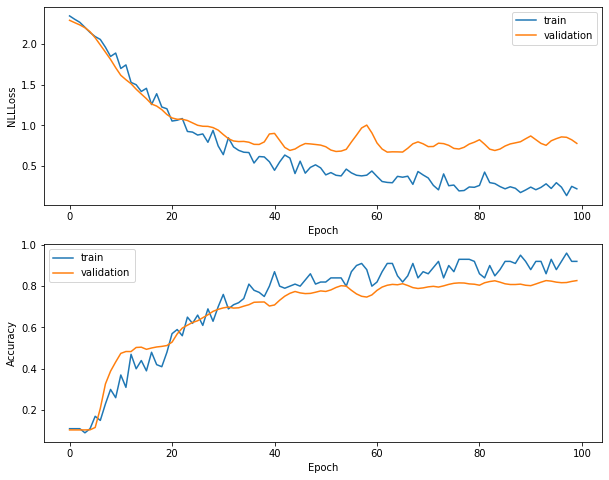

In [32]:
train_losses_pt, val_losses_pt = train_classifier(2*epochs, train_loader_classifier, valid_loader_classifier, classifier_pt, optimizer_classifier_pt, criterion_classifier_pt, hparams)

**Fine-tuning**

In [0]:
feature_extractor = copy.deepcopy(model.encoder.convEncoder)

feature_extractor.to(hparams['device'])

classifier_ft = ConvClassifier(feature_extractor, 3*3*128, dropout*4/5)

In [0]:
optimizer_classifier_ft = optim.Adam([{'params':classifier_ft.encoder.to(hparams['device']).parameters(), 'lr':1e-5},
                                      {'params':classifier_ft.mlp.to(hparams['device']).parameters(), 'lr':1e-3}])
criterion_classifier_ft = F.nll_loss

[TRAIN] epoch 1 : Loss 2.3153841209411623, Accuracy 12.
[VAL] 	epoch 1 : Loss 2.2533500061035157, Accuracy 16.
[TRAIN] epoch 2 : Loss 2.2394221115112303, Accuracy 10.
[VAL] 	epoch 2 : Loss 2.205847953033447, Accuracy 20.
[TRAIN] epoch 3 : Loss 2.1832930278778075, Accuracy 16.
[VAL] 	epoch 3 : Loss 2.159043240737915, Accuracy 23.
[TRAIN] epoch 4 : Loss 2.137981195449829, Accuracy 19.
[VAL] 	epoch 4 : Loss 2.114647570037842, Accuracy 28.
[TRAIN] epoch 5 : Loss 2.070747385025024, Accuracy 25.
[VAL] 	epoch 5 : Loss 2.065779490280151, Accuracy 32.
[TRAIN] epoch 6 : Loss 2.0293281507492065, Accuracy 35.
[VAL] 	epoch 6 : Loss 2.014861298561096, Accuracy 36.
[TRAIN] epoch 7 : Loss 2.036180830001831, Accuracy 32.
[VAL] 	epoch 7 : Loss 1.9601912664413452, Accuracy 38.
[TRAIN] epoch 8 : Loss 1.8821477317810058, Accuracy 32.
[VAL] 	epoch 8 : Loss 1.8975031658172608, Accuracy 38.
[TRAIN] epoch 9 : Loss 1.8192596530914307, Accuracy 38.
[VAL] 	epoch 9 : Loss 1.8290292499542236, Accuracy 40.
[TRAIN] e

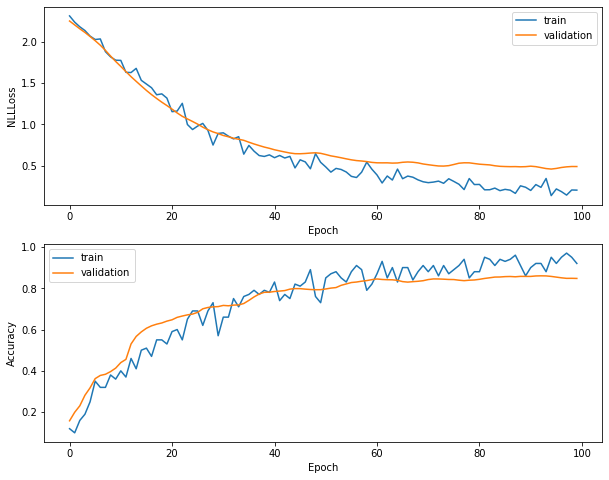

In [35]:
train_losses_ft, val_losses_ft = train_classifier(2*epochs, train_loader_classifier, valid_loader_classifier, classifier_ft, optimizer_classifier_ft, criterion_classifier_ft, hparams)

**Scratch**

In [0]:
feature_extractor = nn.Sequential(
        nn.Conv2d(1, 32, 3,  padding=1),  # 28 x 28 x 32
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),  # 14 x 14 x 32
        nn.Conv2d(32, 64, 3, padding=1),  # 14 x 14 x 64
        nn.ReLU(True),
        nn.MaxPool2d(2, 2),  # 7 x 7 x 64
        nn.Conv2d(64, 128, 3, padding=1),  # 7 x 7 x 128
        nn.ReLU(True),
        nn.MaxPool2d(2, 2) # 3 x 3 x 128
    )

feature_extractor.to(hparams['device'])

classifier_sc = ConvClassifier(feature_extractor, 3*3*128, dropout*5/4)

In [0]:
optimizer_classifier_sc = optim.Adam(classifier_sc.to(hparams['device']).parameters(), lr=hparams['learning_rate'])
criterion_classifier_sc = F.nll_loss

[TRAIN] epoch 1 : Loss 2.304167652130127, Accuracy 10.
[VAL] 	epoch 1 : Loss 2.3060976230621337, Accuracy 10.
[TRAIN] epoch 2 : Loss 2.2944783687591555, Accuracy 10.
[VAL] 	epoch 2 : Loss 2.305435849380493, Accuracy 10.
[TRAIN] epoch 3 : Loss 2.2967951583862303, Accuracy 11.
[VAL] 	epoch 3 : Loss 2.304188663101196, Accuracy 10.
[TRAIN] epoch 4 : Loss 2.3059535312652586, Accuracy 11.
[VAL] 	epoch 4 : Loss 2.3034667221069336, Accuracy 10.
[TRAIN] epoch 5 : Loss 2.2926367950439452, Accuracy 11.
[VAL] 	epoch 5 : Loss 2.3031509227752687, Accuracy 10.
[TRAIN] epoch 6 : Loss 2.280861597061157, Accuracy 13.
[VAL] 	epoch 6 : Loss 2.303316939163208, Accuracy 10.
[TRAIN] epoch 7 : Loss 2.3040024185180665, Accuracy 11.
[VAL] 	epoch 7 : Loss 2.3039214992523194, Accuracy 10.
[TRAIN] epoch 8 : Loss 2.273066644668579, Accuracy 12.
[VAL] 	epoch 8 : Loss 2.30509853515625, Accuracy 10.
[TRAIN] epoch 9 : Loss 2.3094926071166992, Accuracy 10.
[VAL] 	epoch 9 : Loss 2.3034672370910645, Accuracy 10.
[TRAIN] e

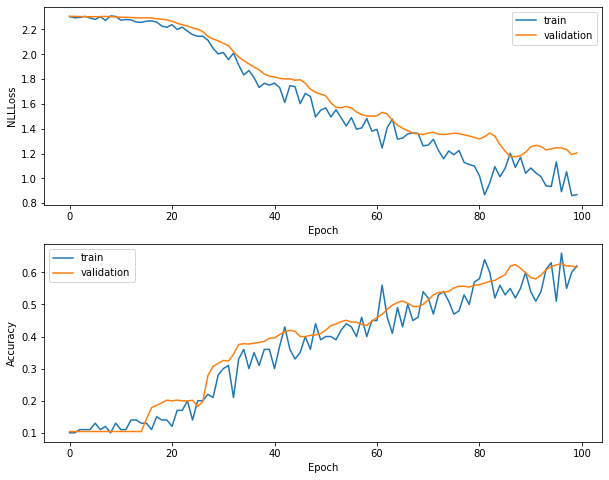

In [38]:
train_losses_sc, val_losses_sc = train_classifier(2*epochs, train_loader_classifier, valid_loader_classifier, classifier_sc, optimizer_classifier_sc, criterion_classifier_sc, hparams)

In [70]:
table = PrettyTable()
table.field_names = ["Pre-training", "Fine-tuning", "Scratch"]

table.add_row([test_classifier(test_loader,classifier_pt), test_classifier(test_loader,classifier_ft), test_classifier(test_loader,classifier_sc)])

print(table)

+--------------+-------------+---------+
| Pre-training | Fine-tuning | Scratch |
+--------------+-------------+---------+
|    0.8285    |    0.8548   |  0.6173 |
+--------------+-------------+---------+


---
# **Optional exercise A: Variational Autoencoder**
---

For the variational autoencoder, we will add an extra layer between the final fully conected layer of the encoder and the start of the decoder. This extra layer will take as input the features extracted form the decoder (Now we call to the encoder bottleneck hidden layer size, as the bottleneck occurs between both of them now).

Once we have these features extracted from encder, the two extra layer we add with bottleneck size dimension will output the mean and variance that will map our input to a Normal distribution output with the correspond mean and variance. So now, the bottleneck sizes reflects the dimensionality of how many Normal distribution we map out data to.  

Reparametrization trick:
z= mean + variance 

> z= mean+ logvariance^(0.5) x N(0,1)


In [40]:
class ConvDecoder_Variational(nn.Module):
  def __init__(self, hidden_layer = 50, bottleneck=10):
    super().__init__()
    
    self.mlpDecoder = nn.Sequential(
        nn.Linear(bottleneck,hidden_layer),
        nn.ReLU(),
        nn.Linear(hidden_layer, 2*2*64),
        nn.ReLU()
    )

    self.conDecoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 3, stride=2),  # 5 x 5 x 32
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),  # 15 x 15 x 16
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),  # 28 x 28 x 1
        nn.Sigmoid()
    )
          
  def forward(self, x):
    x = self.mlpDecoder(x)
    x = x.view(x.shape[0], 64, 2, 2)
    x = self.conDecoder(x)      
    return x

# Print decoder
print(ConvDecoder())

ConvDecoder(
  (mlpDecoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
  )
  (conDecoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [0]:
class VariationalConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, hidden_layer_size= 50, bottleneck=10):
        super().__init__()

        self.fc_mean=nn.Linear(hidden_layer_size, bottleneck)
        self.fc_variance=nn.Linear(hidden_layer_size, bottleneck)

        self.encoder = ConvEncoder(hidden_layer_size)
        self.decoder = ConvDecoder_Variational(hidden_layer_size, bottleneck)
    
    def reparametrization(self, mu, logvar):
        std= torch.exp(0.5*logvar)
        eps = torch.randn_like(std) #Returns sample from N(0,1) same size as input
        return mu + eps*std
    
    def forward(self, x):
        encoder_output = self.encoder(x)
        mean= self.fc_mean(encoder_output)
        logvar= self.fc_variance(encoder_output)
        z= self.reparametrization(mean, logvar)
        reconstruction = self.decoder(z)

        return reconstruction, mean, logvar
    

For this new model, we have to modify the loss function, as we want our model learn to reporesent the input data on a Normal distribution with mean=0 and variance=0.5. So we have to add to the recostruction loss as we previously had (MSE reconstruction loss) the KLD loss, which measures how two distributions look similar to each other.

![](https://drive.google.com/uc?id=1MWbW8x1RT3e3gqE3WmfK_S8pzLsrMD0S)

Credit: Santiago Pascual





In [0]:
def loss_function(reconstruction, x,  mean, logvar):
    
    reconstruction_loss = F.mse_loss(reconstruction, x, reduction= 'sum')
    KLD_loss = -0.5 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())

    return reconstruction_loss + KLD_loss

In [0]:
def validate_epoch_VAE(valid_loader, network):
  network.eval()

  valid_loss = 0.0

  with torch.no_grad():
    for data in valid_loader:
      images, _ = data
      images = images.to(device)
      outputs, mean, variance = network(images)
      loss = loss_function(outputs, images, mean, variance)
      
      valid_loss += loss.item()
      
  
  return valid_loss/len(valid_loader)

In [0]:
def train_network_VAE(train_loader, valid_loader, network, optimizer):
  # Activate the train=True flag inside the model
  network.train()
  train_loss_record= []
  validation_loss_record= []
  for epoch in range(1, hparams['num_epochs'] + 1):
    train_loss = 0.0  # monitor training loss
    for data in train_loader:
      images, _ = data                        # we are just intrested in just images
      # no need to flatten images
      images = images.to(device)
      optimizer.zero_grad()                   # clear the gradients
      outputs, mean, variance = network(images)                 # forward pass: compute predicted outputs 
      loss = loss_function(outputs, images, mean, variance)       # calculate the loss
      loss.backward()                         # backward pass
      optimizer.step()                        # perform optimization step
      train_loss_record.append(loss.item())
      train_loss += loss.item() # update running training loss
      

    #Overall loss or loss average of train images
    val_loss= validate_epoch_VAE(valid_loader, network)
    validation_loss_record.append(val_loss)

    print(f"Train loss {epoch}: {train_loss/len(train_loader)}")
    print(f"Validation loss {epoch}: {val_loss}")

  return train_loss_record, validation_loss_record

In [45]:
variational_autoencoder=  VariationalConvolutionalAutoencoder().cuda()
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=hparams['learning_rate'])


train_loss, validation_loss= train_network_VAE(train_loader, valid_loader, variational_autoencoder, optimizer)

Train loss 2: 7996.371662589436
Validation loss 2: 7063.53057471742
Train loss 3: 6926.768095999053
Validation loss 3: 6739.896764876995
Train loss 4: 6689.704511477624
Validation loss 4: 6484.928949883643
Train loss 5: 6474.43401900954
Validation loss 5: 6352.89783494016
Train loss 6: 6373.295521951283
Validation loss 6: 6309.416067569814
Train loss 7: 6317.271535340383
Validation loss 7: 6244.439089511303
Train loss 8: 6280.178861093575
Validation loss 8: 6228.649538730053
Train loss 9: 6250.724163016887
Validation loss 9: 6204.004539976729
Train loss 10: 6226.869366955142
Validation loss 10: 6177.23816697141
Train loss 11: 6200.748651883418
Validation loss 11: 6142.085428440824
Train loss 12: 6177.096775042088
Validation loss 12: 6131.770040309176
Train loss 13: 6162.872569554047
Validation loss 13: 6124.996945644947
Train loss 14: 6148.268593870564
Validation loss 14: 6096.56591796875
Train loss 15: 6132.329262130857
Validation loss 15: 6075.154618932846
Train loss 16: 6117.0843337

### Generate 5 new images by injecting random values as input to the decoder.

The problem with AutoEncoders is that they learn to memorize the reconstruction of certain values, but they do not generalize to represent the structure (distribution) of the input. Varational autoencoders are supposed to solve this, making the network learn how to generate samples based on particular values we get from the distribution we learn.
This means that NOW we should be able to see new samples from mnsit from just Gaussian Noise input to the decoder. Let's see. 

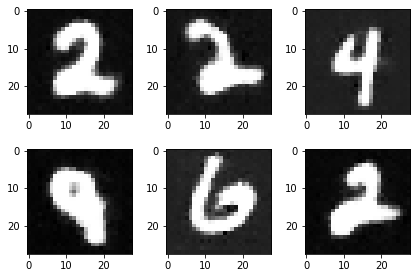

In [46]:
with torch.no_grad():
  inputs = torch.randn(6, 10).cuda()
  output = variational_autoencoder.decoder(inputs)
  output = output.cpu().detach().numpy()  
  fig = plt.figure()
  for i in range(6):  
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(output[i][0], cmap='gray', interpolation='none')

---
# **Optional exercise B: Conditional GAN**
---

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

        self.label_fc= nn.Sequential(
            nn.Linear(10, 256*4*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.image_fc= nn.Sequential(
            nn.Linear(100, 768*4*4),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, g_labels):
        # Noise to image
        g_labels = self.label_fc(g_labels)
        g_image = self.image_fc(x)

        g_image= g_image.view(g_image.shape[0], 768, 4, 4)
        g_labels= g_labels.view(g_labels.shape[0], 256, 4, 4)
        
        x = torch.cat([g_image, g_labels], 1)
        x = self._conv1(x)
        x = self._conv2(x)
        return self._conv3(x)

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.label_fc= nn.Sequential(
            nn.Linear(10, 1024),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )


    def forward(self, x, labels):
        # Classify image as fake or real
        _label= self.label_fc(labels)
        _label= _label.view(-1, 1, 32, 32)
        x = torch.cat([x,_label], 1)
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x= x.view(-1, 512*4*4)
        output= self._fc(x)
        
        return output

In [0]:
class Model:
  
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None, one_hot_labels=None):
        # sample random noise
        
        if z is None:
          z = norm_noise(batch_size)
        #cretae random labels
        if one_hot_labels is None:
          one_hot_rand_labels= torch.FloatTensor(batch_size, 10).zero_()
          rand_labels = torch.from_numpy(np.random.randint(0, 10, size=(batch_size,1)))
          one_hot_rand_labels.scatter_(1, rand_labels.view(batch_size,1), 1)
          one_hot_labels = Variable(one_hot_rand_labels).cuda()
          

        # Generate fake samples out of the random noise z and the labels.
        fake_samples = self._generator(z, one_hot_labels)
        return fake_samples, one_hot_labels
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, real_labels):
        #Generate samples
        fake_samples, one_hot_rand_labelsV = self.generate_samples(real_samples.size(0))
        
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, one_hot_rand_labelsV)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, real_labels, fake_samples.detach(), one_hot_rand_labelsV)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, rand_labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # Calculate generator loss
        estim_fake = self._discriminator(fake_samples, rand_labels)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()

    def _step_opt_d(self, real_samples, real_labels, fake_samples, rand_labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, real_labels)
        loss_real = self._criterion(estim_real, self._label_real)
        loss_real.backward()
        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, rand_labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        loss_fake.backward()      

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

In [0]:
num_epochs = 10
num_val_samples = 30
z_val = norm_noise(num_val_samples).cuda()
labels_val = torch.zeros(num_val_samples, 10)
for i in range(10):
  for j in range(num_val_samples // 10):
    labels_val[i*(num_val_samples // 10) + j, i] = 1.0
labels_val= labels_val.cuda()
model = Model(batch_size)

epoch: 0/10, batch: 0/600, G_loss: 0.698253333568573, D_loss: (0.6980841755867004, 0.6880680322647095)


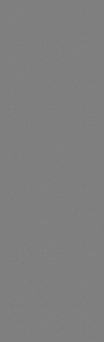

epoch: 0/10, batch: 10/600, G_loss: 1.7767144441604614, D_loss: (0.1934036761522293, 0.18557605147361755)
epoch: 0/10, batch: 20/600, G_loss: 3.6301751136779785, D_loss: (0.028123389929533005, 0.026964500546455383)
epoch: 0/10, batch: 30/600, G_loss: 4.614400863647461, D_loss: (0.01048427913337946, 0.009978403337299824)
epoch: 0/10, batch: 40/600, G_loss: 5.186898231506348, D_loss: (0.005769348703324795, 0.005620803218334913)
epoch: 0/10, batch: 50/600, G_loss: 5.595695972442627, D_loss: (0.0036316586192697287, 0.0037850963417440653)
epoch: 0/10, batch: 60/600, G_loss: 6.071838855743408, D_loss: (0.002759485272690654, 0.002375165931880474)
epoch: 0/10, batch: 70/600, G_loss: 6.082137584686279, D_loss: (0.0024996616411954165, 0.002472042106091976)
epoch: 0/10, batch: 80/600, G_loss: 3.6710095405578613, D_loss: (0.055000174790620804, 0.026295678690075874)
epoch: 0/10, batch: 90/600, G_loss: 3.0094563961029053, D_loss: (0.020474683493375778, 0.05296184867620468)
epoch: 0/10, batch: 100/60

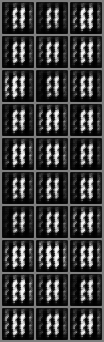

epoch: 0/10, batch: 210/600, G_loss: 2.7659127712249756, D_loss: (0.032972175627946854, 0.06650616973638535)
epoch: 0/10, batch: 220/600, G_loss: 2.4821887016296387, D_loss: (0.06882882863283157, 0.0944557934999466)
epoch: 0/10, batch: 230/600, G_loss: 2.8980536460876465, D_loss: (0.05897752195596695, 0.05997438356280327)
epoch: 0/10, batch: 240/600, G_loss: 3.3063619136810303, D_loss: (0.022789515554904938, 0.038886357098817825)
epoch: 0/10, batch: 250/600, G_loss: 2.372845411300659, D_loss: (0.07248435169458389, 0.12154664844274521)
epoch: 0/10, batch: 260/600, G_loss: 3.04622745513916, D_loss: (0.03552456945180893, 0.07942110300064087)
epoch: 0/10, batch: 270/600, G_loss: 3.535464286804199, D_loss: (0.033642251044511795, 0.0386100709438324)
epoch: 0/10, batch: 280/600, G_loss: 6.399724006652832, D_loss: (0.008596841245889664, 0.002124628983438015)
epoch: 0/10, batch: 290/600, G_loss: 4.372335910797119, D_loss: (0.048862725496292114, 0.014818241819739342)
epoch: 0/10, batch: 300/600,

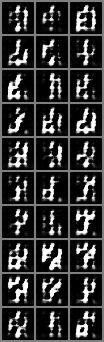

epoch: 0/10, batch: 410/600, G_loss: 3.3455185890197754, D_loss: (0.0706385001540184, 0.048474863171577454)
epoch: 0/10, batch: 420/600, G_loss: 2.90651273727417, D_loss: (0.07577762007713318, 0.09702034294605255)
epoch: 0/10, batch: 430/600, G_loss: 2.8561103343963623, D_loss: (0.06864523142576218, 0.0929534062743187)
epoch: 0/10, batch: 440/600, G_loss: 3.6098833084106445, D_loss: (0.09445688128471375, 0.05881844833493233)
epoch: 0/10, batch: 450/600, G_loss: 2.1118433475494385, D_loss: (0.15005473792552948, 0.3202246427536011)
epoch: 0/10, batch: 460/600, G_loss: 4.365401268005371, D_loss: (0.139809712767601, 0.019948182627558708)
epoch: 0/10, batch: 470/600, G_loss: 2.3900861740112305, D_loss: (0.008394322358071804, 0.3159678876399994)
epoch: 0/10, batch: 480/600, G_loss: 3.4308600425720215, D_loss: (0.17447443306446075, 0.0677274838089943)
epoch: 0/10, batch: 490/600, G_loss: 3.8146872520446777, D_loss: (0.2229924350976944, 0.04716343432664871)
epoch: 0/10, batch: 500/600, G_loss:

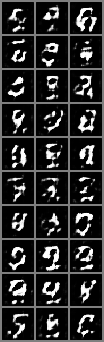

epoch: 1/10, batch: 10/600, G_loss: 3.892784833908081, D_loss: (0.11756441742181778, 0.06177877262234688)
epoch: 1/10, batch: 20/600, G_loss: 3.4113264083862305, D_loss: (0.11288642138242722, 0.09723755717277527)
epoch: 1/10, batch: 30/600, G_loss: 1.8068767786026, D_loss: (0.01826619915664196, 0.6056697368621826)
epoch: 1/10, batch: 40/600, G_loss: 2.226738452911377, D_loss: (0.032061632722616196, 0.33675774931907654)
epoch: 1/10, batch: 50/600, G_loss: 2.8946917057037354, D_loss: (0.0914468839764595, 0.1688271164894104)
epoch: 1/10, batch: 60/600, G_loss: 3.3660290241241455, D_loss: (0.14752602577209473, 0.14643441140651703)
epoch: 1/10, batch: 70/600, G_loss: 0.5626279711723328, D_loss: (0.008938809856772423, 1.9662234783172607)
epoch: 1/10, batch: 80/600, G_loss: 2.7058353424072266, D_loss: (0.17261797189712524, 0.234306201338768)
epoch: 1/10, batch: 90/600, G_loss: 3.2546379566192627, D_loss: (0.08092216402292252, 0.13223357498645782)
epoch: 1/10, batch: 100/600, G_loss: 3.4156911

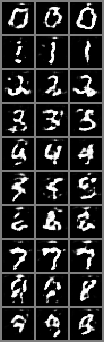

epoch: 1/10, batch: 210/600, G_loss: 2.3977372646331787, D_loss: (0.26105257868766785, 0.2621379792690277)
epoch: 1/10, batch: 220/600, G_loss: 3.3334927558898926, D_loss: (0.33172526955604553, 0.14072781801223755)
epoch: 1/10, batch: 230/600, G_loss: 1.0183337926864624, D_loss: (0.012155805714428425, 0.9648905992507935)
epoch: 1/10, batch: 240/600, G_loss: 1.6354882717132568, D_loss: (0.0818607434630394, 0.5231581926345825)
epoch: 1/10, batch: 250/600, G_loss: 1.5601826906204224, D_loss: (0.07604130357503891, 0.518291711807251)
epoch: 1/10, batch: 260/600, G_loss: 3.8452672958374023, D_loss: (0.3554914891719818, 0.05616354942321777)
epoch: 1/10, batch: 270/600, G_loss: 2.718449592590332, D_loss: (0.10118558257818222, 0.1602359265089035)
epoch: 1/10, batch: 280/600, G_loss: 3.713350772857666, D_loss: (0.3561752438545227, 0.06907755136489868)
epoch: 1/10, batch: 290/600, G_loss: 2.2253847122192383, D_loss: (0.13917100429534912, 0.2886519730091095)
epoch: 1/10, batch: 300/600, G_loss: 4.

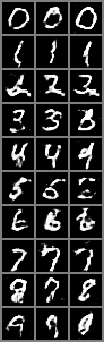

epoch: 1/10, batch: 410/600, G_loss: 2.1552481651306152, D_loss: (0.1308421641588211, 0.3109535276889801)
epoch: 1/10, batch: 420/600, G_loss: 1.872261643409729, D_loss: (0.06374295055866241, 0.3846161365509033)
epoch: 1/10, batch: 430/600, G_loss: 2.5693981647491455, D_loss: (0.2640160918235779, 0.16337130963802338)
epoch: 1/10, batch: 440/600, G_loss: 1.540492057800293, D_loss: (0.11067125201225281, 0.5282719135284424)
epoch: 1/10, batch: 450/600, G_loss: 2.1209120750427246, D_loss: (0.11590749770402908, 0.2966887354850769)
epoch: 1/10, batch: 460/600, G_loss: 0.9394670128822327, D_loss: (0.04250616207718849, 0.9941418170928955)
epoch: 1/10, batch: 470/600, G_loss: 3.658372402191162, D_loss: (0.6257076859474182, 0.06271986663341522)
epoch: 1/10, batch: 480/600, G_loss: 3.5730276107788086, D_loss: (0.27801066637039185, 0.06224627420306206)
epoch: 1/10, batch: 490/600, G_loss: 1.8564120531082153, D_loss: (0.08513344079256058, 0.35212942957878113)
epoch: 1/10, batch: 500/600, G_loss: 3.

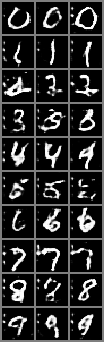

epoch: 2/10, batch: 10/600, G_loss: 4.8407135009765625, D_loss: (1.2835067510604858, 0.013505710288882256)
epoch: 2/10, batch: 20/600, G_loss: 1.7690566778182983, D_loss: (0.11032138019800186, 0.40573084354400635)
epoch: 2/10, batch: 30/600, G_loss: 1.6351730823516846, D_loss: (0.15002891421318054, 0.4767138659954071)
epoch: 2/10, batch: 40/600, G_loss: 2.8965909481048584, D_loss: (0.5592557787895203, 0.125003382563591)
epoch: 2/10, batch: 50/600, G_loss: 3.1711606979370117, D_loss: (0.5241116881370544, 0.0894434005022049)
epoch: 2/10, batch: 60/600, G_loss: 4.230703353881836, D_loss: (1.1315867900848389, 0.03849703446030617)
epoch: 2/10, batch: 70/600, G_loss: 2.417311429977417, D_loss: (0.4531969428062439, 0.1878121793270111)
epoch: 2/10, batch: 80/600, G_loss: 0.8369348645210266, D_loss: (0.08922124654054642, 0.9543008208274841)
epoch: 2/10, batch: 90/600, G_loss: 2.633186101913452, D_loss: (0.29879218339920044, 0.18824590742588043)
epoch: 2/10, batch: 100/600, G_loss: 1.12165379524

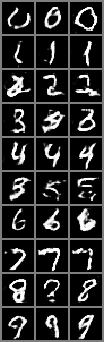

epoch: 2/10, batch: 210/600, G_loss: 2.902024269104004, D_loss: (0.6446743607521057, 0.09872381389141083)
epoch: 2/10, batch: 220/600, G_loss: 2.298243761062622, D_loss: (0.2946532368659973, 0.18569150567054749)
epoch: 2/10, batch: 230/600, G_loss: 2.792421340942383, D_loss: (0.831451416015625, 0.11142846941947937)
epoch: 2/10, batch: 240/600, G_loss: 1.7297658920288086, D_loss: (0.3101591169834137, 0.3071744441986084)
epoch: 2/10, batch: 250/600, G_loss: 1.056971788406372, D_loss: (0.09278373420238495, 0.673840343952179)
epoch: 2/10, batch: 260/600, G_loss: 2.644404411315918, D_loss: (0.7956799268722534, 0.14690832793712616)
epoch: 2/10, batch: 270/600, G_loss: 1.4292140007019043, D_loss: (0.32767149806022644, 0.48438191413879395)
epoch: 2/10, batch: 280/600, G_loss: 1.4315780401229858, D_loss: (0.33285704255104065, 0.512127161026001)
epoch: 2/10, batch: 290/600, G_loss: 1.9864492416381836, D_loss: (0.26373982429504395, 0.2511499524116516)
epoch: 2/10, batch: 300/600, G_loss: 3.435576

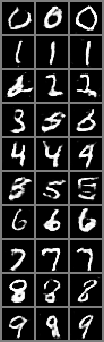

epoch: 2/10, batch: 410/600, G_loss: 3.4899306297302246, D_loss: (0.977530837059021, 0.05397230014204979)
epoch: 2/10, batch: 420/600, G_loss: 1.5226002931594849, D_loss: (0.5694903135299683, 0.4261869788169861)
epoch: 2/10, batch: 430/600, G_loss: 1.0400303602218628, D_loss: (0.24909019470214844, 0.7504003643989563)
epoch: 2/10, batch: 440/600, G_loss: 1.8566142320632935, D_loss: (0.810056209564209, 0.32028427720069885)
epoch: 2/10, batch: 450/600, G_loss: 1.015658974647522, D_loss: (0.20821525156497955, 0.733424961566925)
epoch: 2/10, batch: 460/600, G_loss: 0.683713972568512, D_loss: (0.13001395761966705, 1.0489702224731445)
epoch: 2/10, batch: 470/600, G_loss: 2.0145609378814697, D_loss: (0.36313965916633606, 0.23883433640003204)
epoch: 2/10, batch: 480/600, G_loss: 2.0747547149658203, D_loss: (0.3718501627445221, 0.22507578134536743)
epoch: 2/10, batch: 490/600, G_loss: 1.7696377038955688, D_loss: (0.2876741290092468, 0.2911616265773773)
epoch: 2/10, batch: 500/600, G_loss: 1.7076

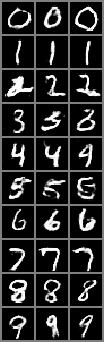

epoch: 3/10, batch: 10/600, G_loss: 0.6613003611564636, D_loss: (0.05706982687115669, 1.0833139419555664)
epoch: 3/10, batch: 20/600, G_loss: 3.348978042602539, D_loss: (1.6990257501602173, 0.06753585487604141)
epoch: 3/10, batch: 30/600, G_loss: 1.5966836214065552, D_loss: (0.5362926721572876, 0.36044612526893616)
epoch: 3/10, batch: 40/600, G_loss: 2.348158597946167, D_loss: (0.523400068283081, 0.15486319363117218)
epoch: 3/10, batch: 50/600, G_loss: 1.167309284210205, D_loss: (0.19733621180057526, 0.565656840801239)
epoch: 3/10, batch: 60/600, G_loss: 0.8279650211334229, D_loss: (0.15980245172977448, 0.850760281085968)
epoch: 3/10, batch: 70/600, G_loss: 1.137549877166748, D_loss: (0.2235308140516281, 0.5901505947113037)
epoch: 3/10, batch: 80/600, G_loss: 1.6446681022644043, D_loss: (0.4211069941520691, 0.3980211615562439)
epoch: 3/10, batch: 90/600, G_loss: 1.1475111246109009, D_loss: (0.36286765336990356, 0.5241646766662598)
epoch: 3/10, batch: 100/600, G_loss: 1.5162315368652344

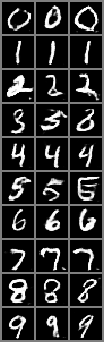

epoch: 3/10, batch: 210/600, G_loss: 1.6249531507492065, D_loss: (0.737189769744873, 0.3181530833244324)
epoch: 3/10, batch: 220/600, G_loss: 1.8972587585449219, D_loss: (0.45730170607566833, 0.33767005801200867)
epoch: 3/10, batch: 230/600, G_loss: 1.9468553066253662, D_loss: (0.31044626235961914, 0.2760026156902313)
epoch: 3/10, batch: 240/600, G_loss: 0.4954769015312195, D_loss: (0.06972551345825195, 1.3975329399108887)
epoch: 3/10, batch: 250/600, G_loss: 0.7578641772270203, D_loss: (0.10615198314189911, 0.8762762546539307)
epoch: 3/10, batch: 260/600, G_loss: 1.8021361827850342, D_loss: (0.5017022490501404, 0.28728601336479187)
epoch: 3/10, batch: 270/600, G_loss: 1.2512115240097046, D_loss: (0.2853144407272339, 0.4969809651374817)
epoch: 3/10, batch: 280/600, G_loss: 1.1072906255722046, D_loss: (0.19069357216358185, 0.5728501677513123)
epoch: 3/10, batch: 290/600, G_loss: 2.135469675064087, D_loss: (0.8068833947181702, 0.1758345067501068)
epoch: 3/10, batch: 300/600, G_loss: 2.37

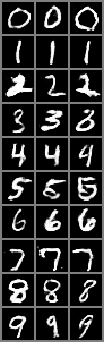

epoch: 3/10, batch: 410/600, G_loss: 2.3810410499572754, D_loss: (0.6404995918273926, 0.1533789485692978)
epoch: 3/10, batch: 420/600, G_loss: 2.13797664642334, D_loss: (0.5211885571479797, 0.19029730558395386)
epoch: 3/10, batch: 430/600, G_loss: 2.730220317840576, D_loss: (0.629067599773407, 0.10508366674184799)
epoch: 3/10, batch: 440/600, G_loss: 2.4326882362365723, D_loss: (0.8914363980293274, 0.14211000502109528)
epoch: 3/10, batch: 450/600, G_loss: 1.6663792133331299, D_loss: (0.5531001091003418, 0.3994196951389313)
epoch: 3/10, batch: 460/600, G_loss: 1.592072606086731, D_loss: (0.2980627715587616, 0.4095040559768677)
epoch: 3/10, batch: 470/600, G_loss: 1.4296314716339111, D_loss: (0.3352682590484619, 0.4414195120334625)
epoch: 3/10, batch: 480/600, G_loss: 1.9374366998672485, D_loss: (0.4701113998889923, 0.268586128950119)
epoch: 3/10, batch: 490/600, G_loss: 2.198845386505127, D_loss: (0.45831534266471863, 0.20565149188041687)
epoch: 3/10, batch: 500/600, G_loss: 1.950424075

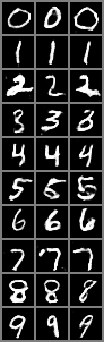

epoch: 4/10, batch: 10/600, G_loss: 1.956757664680481, D_loss: (0.8198095560073853, 0.22974544763565063)
epoch: 4/10, batch: 20/600, G_loss: 0.6733057498931885, D_loss: (0.17010028660297394, 1.0579781532287598)
epoch: 4/10, batch: 30/600, G_loss: 1.7181029319763184, D_loss: (0.41304612159729004, 0.28805699944496155)
epoch: 4/10, batch: 40/600, G_loss: 1.0170320272445679, D_loss: (0.1441868394613266, 0.7390591502189636)
epoch: 4/10, batch: 50/600, G_loss: 2.322766065597534, D_loss: (0.7304389476776123, 0.16714279353618622)
epoch: 4/10, batch: 60/600, G_loss: 1.7771836519241333, D_loss: (0.16529756784439087, 0.3093957006931305)
epoch: 4/10, batch: 70/600, G_loss: 0.35283955931663513, D_loss: (0.0628192126750946, 1.8450596332550049)
epoch: 4/10, batch: 80/600, G_loss: 0.6532010436058044, D_loss: (0.23448309302330017, 0.9759573936462402)
epoch: 4/10, batch: 90/600, G_loss: 1.349694848060608, D_loss: (0.27039840817451477, 0.41136792302131653)
epoch: 4/10, batch: 100/600, G_loss: 1.806144833

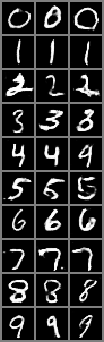

epoch: 4/10, batch: 210/600, G_loss: 2.386963367462158, D_loss: (0.5928195118904114, 0.15759408473968506)
epoch: 4/10, batch: 220/600, G_loss: 2.0136208534240723, D_loss: (0.4918299913406372, 0.22148838639259338)
epoch: 4/10, batch: 230/600, G_loss: 0.900287389755249, D_loss: (0.11809196323156357, 0.7411141395568848)
epoch: 4/10, batch: 240/600, G_loss: 1.8412662744522095, D_loss: (0.4593999981880188, 0.2701195776462555)
epoch: 4/10, batch: 250/600, G_loss: 1.17290461063385, D_loss: (0.20990385115146637, 0.5048950910568237)
epoch: 4/10, batch: 260/600, G_loss: 0.43915992975234985, D_loss: (0.10103662312030792, 1.3474030494689941)
epoch: 4/10, batch: 270/600, G_loss: 1.8237391710281372, D_loss: (0.4636248052120209, 0.26073816418647766)
epoch: 4/10, batch: 280/600, G_loss: 2.501915454864502, D_loss: (0.7268860340118408, 0.139995276927948)
epoch: 4/10, batch: 290/600, G_loss: 1.2394245862960815, D_loss: (0.3179394602775574, 0.5067685842514038)
epoch: 4/10, batch: 300/600, G_loss: 0.962518

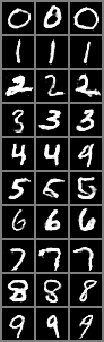

epoch: 4/10, batch: 410/600, G_loss: 2.4151597023010254, D_loss: (0.7811143398284912, 0.13934646546840668)
epoch: 4/10, batch: 420/600, G_loss: 1.5476919412612915, D_loss: (0.34784233570098877, 0.3673449754714966)
epoch: 4/10, batch: 430/600, G_loss: 2.496180534362793, D_loss: (0.9312253594398499, 0.14981131255626678)
epoch: 4/10, batch: 440/600, G_loss: 0.45523345470428467, D_loss: (0.0806172788143158, 1.288541555404663)
epoch: 4/10, batch: 450/600, G_loss: 1.7052918672561646, D_loss: (0.4803899824619293, 0.2785003185272217)
epoch: 4/10, batch: 460/600, G_loss: 0.7773995399475098, D_loss: (0.10702677071094513, 0.872954249382019)
epoch: 4/10, batch: 470/600, G_loss: 0.9452840685844421, D_loss: (0.29023730754852295, 0.7145553827285767)
epoch: 4/10, batch: 480/600, G_loss: 1.5978480577468872, D_loss: (0.17114515602588654, 0.34518176317214966)
epoch: 4/10, batch: 490/600, G_loss: 1.3453574180603027, D_loss: (0.30694258213043213, 0.44196560978889465)
epoch: 4/10, batch: 500/600, G_loss: 2.

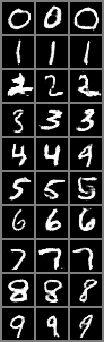

epoch: 5/10, batch: 10/600, G_loss: 1.0095711946487427, D_loss: (0.3557577431201935, 0.7118406891822815)
epoch: 5/10, batch: 20/600, G_loss: 2.605905055999756, D_loss: (1.1236069202423096, 0.11574935168027878)
epoch: 5/10, batch: 30/600, G_loss: 1.5288453102111816, D_loss: (0.6108162999153137, 0.36714455485343933)
epoch: 5/10, batch: 40/600, G_loss: 2.831860303878784, D_loss: (1.0606273412704468, 0.08440569788217545)
epoch: 5/10, batch: 50/600, G_loss: 1.4598479270935059, D_loss: (0.175154909491539, 0.37862613797187805)
epoch: 5/10, batch: 60/600, G_loss: 1.5540084838867188, D_loss: (0.8929126858711243, 0.3331155478954315)
epoch: 5/10, batch: 70/600, G_loss: 2.284310817718506, D_loss: (0.642882227897644, 0.15087932348251343)
epoch: 5/10, batch: 80/600, G_loss: 2.891411542892456, D_loss: (1.0971254110336304, 0.08278816193342209)
epoch: 5/10, batch: 90/600, G_loss: 1.1838587522506714, D_loss: (0.200608029961586, 0.5280904173851013)
epoch: 5/10, batch: 100/600, G_loss: 0.9943428635597229,

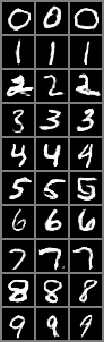

epoch: 5/10, batch: 210/600, G_loss: 2.2143473625183105, D_loss: (1.0285778045654297, 0.16665758192539215)
epoch: 5/10, batch: 220/600, G_loss: 2.122506618499756, D_loss: (0.44778308272361755, 0.17880907654762268)
epoch: 5/10, batch: 230/600, G_loss: 0.6674655675888062, D_loss: (0.16701991856098175, 0.9519367218017578)
epoch: 5/10, batch: 240/600, G_loss: 0.8874174356460571, D_loss: (0.2251608669757843, 0.7291123867034912)
epoch: 5/10, batch: 250/600, G_loss: 0.8385462164878845, D_loss: (0.3141454756259918, 0.6938228607177734)
epoch: 5/10, batch: 260/600, G_loss: 1.1953390836715698, D_loss: (0.24621842801570892, 0.5369396805763245)
epoch: 5/10, batch: 270/600, G_loss: 0.6454934477806091, D_loss: (0.12414724379777908, 1.1106607913970947)
epoch: 5/10, batch: 280/600, G_loss: 2.679025173187256, D_loss: (1.112207055091858, 0.09964564442634583)
epoch: 5/10, batch: 290/600, G_loss: 2.250244617462158, D_loss: (0.7349472641944885, 0.1616981327533722)
epoch: 5/10, batch: 300/600, G_loss: 0.9601

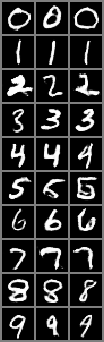

epoch: 5/10, batch: 410/600, G_loss: 0.5119750499725342, D_loss: (0.07024207711219788, 1.169176697731018)
epoch: 5/10, batch: 420/600, G_loss: 3.1305911540985107, D_loss: (1.2577954530715942, 0.05631722882390022)
epoch: 5/10, batch: 430/600, G_loss: 1.2930138111114502, D_loss: (0.2640380561351776, 0.4673706293106079)
epoch: 5/10, batch: 440/600, G_loss: 0.8451616168022156, D_loss: (0.13384674489498138, 0.7714558243751526)
epoch: 5/10, batch: 450/600, G_loss: 1.3902438879013062, D_loss: (0.3132731318473816, 0.4236525297164917)
epoch: 5/10, batch: 460/600, G_loss: 2.2618091106414795, D_loss: (0.9698767066001892, 0.16429397463798523)
epoch: 5/10, batch: 470/600, G_loss: 1.0017108917236328, D_loss: (0.13991668820381165, 0.6843706369400024)
epoch: 5/10, batch: 480/600, G_loss: 2.2750682830810547, D_loss: (0.8111452460289001, 0.14572200179100037)
epoch: 5/10, batch: 490/600, G_loss: 2.2653775215148926, D_loss: (0.7693552374839783, 0.16307471692562103)
epoch: 5/10, batch: 500/600, G_loss: 2.4

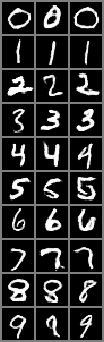

epoch: 6/10, batch: 10/600, G_loss: 2.2012429237365723, D_loss: (0.9867984652519226, 0.16436567902565002)
epoch: 6/10, batch: 20/600, G_loss: 2.606633186340332, D_loss: (1.0862044095993042, 0.11437354981899261)
epoch: 6/10, batch: 30/600, G_loss: 2.182788133621216, D_loss: (0.7386597990989685, 0.16448403894901276)
epoch: 6/10, batch: 40/600, G_loss: 1.5986179113388062, D_loss: (0.3561083972454071, 0.32534629106521606)
epoch: 6/10, batch: 50/600, G_loss: 1.042262077331543, D_loss: (0.13874290883541107, 0.6402559876441956)
epoch: 6/10, batch: 60/600, G_loss: 0.7607266902923584, D_loss: (0.11070790141820908, 0.9366989731788635)
epoch: 6/10, batch: 70/600, G_loss: 2.354077100753784, D_loss: (1.4996429681777954, 0.13989023864269257)
epoch: 6/10, batch: 80/600, G_loss: 1.9501489400863647, D_loss: (0.8084989786148071, 0.21066106855869293)
epoch: 6/10, batch: 90/600, G_loss: 1.246024250984192, D_loss: (0.22129102051258087, 0.48475468158721924)
epoch: 6/10, batch: 100/600, G_loss: 0.51575809717

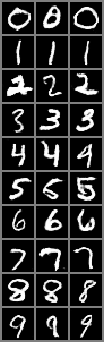

epoch: 6/10, batch: 210/600, G_loss: 1.3117557764053345, D_loss: (0.47036391496658325, 0.4639095664024353)
epoch: 6/10, batch: 220/600, G_loss: 2.5119740962982178, D_loss: (0.929923415184021, 0.129023015499115)
epoch: 6/10, batch: 230/600, G_loss: 3.201620578765869, D_loss: (1.6428594589233398, 0.08510813117027283)
epoch: 6/10, batch: 240/600, G_loss: 1.877642035484314, D_loss: (0.8116441369056702, 0.2570478916168213)
epoch: 6/10, batch: 250/600, G_loss: 1.4245632886886597, D_loss: (0.15274663269519806, 0.38340872526168823)
epoch: 6/10, batch: 260/600, G_loss: 1.3450230360031128, D_loss: (0.2814900577068329, 0.4331241548061371)
epoch: 6/10, batch: 270/600, G_loss: 2.6542181968688965, D_loss: (1.2456070184707642, 0.11706250160932541)
epoch: 6/10, batch: 280/600, G_loss: 0.5098722577095032, D_loss: (0.19722217321395874, 1.2601327896118164)
epoch: 6/10, batch: 290/600, G_loss: 1.517467975616455, D_loss: (0.21596181392669678, 0.34449565410614014)
epoch: 6/10, batch: 300/600, G_loss: 1.1397

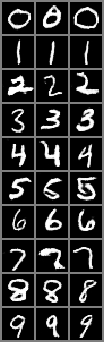

epoch: 6/10, batch: 410/600, G_loss: 1.8229446411132812, D_loss: (0.571165144443512, 0.2528151571750641)
epoch: 6/10, batch: 420/600, G_loss: 2.4987685680389404, D_loss: (0.6048294305801392, 0.12130826711654663)
epoch: 6/10, batch: 430/600, G_loss: 1.1596245765686035, D_loss: (0.3797237277030945, 0.5087121725082397)
epoch: 6/10, batch: 440/600, G_loss: 2.0627970695495605, D_loss: (0.6511479020118713, 0.20851321518421173)
epoch: 6/10, batch: 450/600, G_loss: 0.7567206025123596, D_loss: (0.10238119214773178, 0.8172738552093506)
epoch: 6/10, batch: 460/600, G_loss: 2.1964118480682373, D_loss: (0.7563890814781189, 0.1493273228406906)
epoch: 6/10, batch: 470/600, G_loss: 0.9119911789894104, D_loss: (0.1096104234457016, 0.6822951436042786)
epoch: 6/10, batch: 480/600, G_loss: 1.0255482196807861, D_loss: (0.21578481793403625, 0.5951507687568665)
epoch: 6/10, batch: 490/600, G_loss: 0.6027275919914246, D_loss: (0.14574763178825378, 1.0548293590545654)
epoch: 6/10, batch: 500/600, G_loss: 2.787

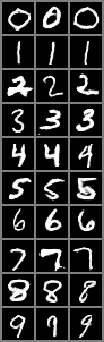

epoch: 7/10, batch: 10/600, G_loss: 2.621122360229492, D_loss: (0.5660269856452942, 0.10709211975336075)
epoch: 7/10, batch: 20/600, G_loss: 1.0234076976776123, D_loss: (0.17261666059494019, 0.6208159923553467)
epoch: 7/10, batch: 30/600, G_loss: 1.164872646331787, D_loss: (0.19976910948753357, 0.49939510226249695)
epoch: 7/10, batch: 40/600, G_loss: 2.1985645294189453, D_loss: (0.802645742893219, 0.16854223608970642)
epoch: 7/10, batch: 50/600, G_loss: 1.5171207189559937, D_loss: (0.6234068870544434, 0.35342204570770264)
epoch: 7/10, batch: 60/600, G_loss: 0.8971731066703796, D_loss: (0.2946867346763611, 0.7151269316673279)
epoch: 7/10, batch: 70/600, G_loss: 0.8856706023216248, D_loss: (0.2852386236190796, 0.7528622150421143)
epoch: 7/10, batch: 80/600, G_loss: 0.46869656443595886, D_loss: (0.08483776450157166, 1.2602020502090454)
epoch: 7/10, batch: 90/600, G_loss: 1.6433041095733643, D_loss: (0.5895361304283142, 0.31922686100006104)
epoch: 7/10, batch: 100/600, G_loss: 1.6744065284

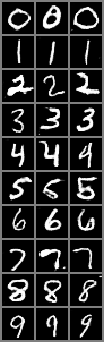

epoch: 7/10, batch: 210/600, G_loss: 1.0573041439056396, D_loss: (0.20350489020347595, 0.6184771060943604)
epoch: 7/10, batch: 220/600, G_loss: 3.0629031658172607, D_loss: (0.7570977210998535, 0.07043513655662537)
epoch: 7/10, batch: 230/600, G_loss: 1.4013161659240723, D_loss: (0.3916547894477844, 0.3996520936489105)
epoch: 7/10, batch: 240/600, G_loss: 0.8954103589057922, D_loss: (0.09413878619670868, 0.7072194814682007)
epoch: 7/10, batch: 250/600, G_loss: 2.3826963901519775, D_loss: (0.8406909108161926, 0.13272824883460999)
epoch: 7/10, batch: 260/600, G_loss: 0.9853467345237732, D_loss: (0.22991304099559784, 0.6074876189231873)
epoch: 7/10, batch: 270/600, G_loss: 0.9564767479896545, D_loss: (0.122775137424469, 0.6831297874450684)
epoch: 7/10, batch: 280/600, G_loss: 1.27100670337677, D_loss: (0.47098156809806824, 0.41468489170074463)
epoch: 7/10, batch: 290/600, G_loss: 1.8381427526474, D_loss: (0.5956628918647766, 0.2906554937362671)
epoch: 7/10, batch: 300/600, G_loss: 2.555391

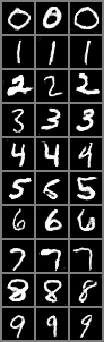

epoch: 7/10, batch: 410/600, G_loss: 0.844832181930542, D_loss: (0.1107669249176979, 0.7533299326896667)
epoch: 7/10, batch: 420/600, G_loss: 0.5529041886329651, D_loss: (0.09506085515022278, 1.1141560077667236)
epoch: 7/10, batch: 430/600, G_loss: 2.766082763671875, D_loss: (0.8543956279754639, 0.09366804361343384)
epoch: 7/10, batch: 440/600, G_loss: 0.8092689514160156, D_loss: (0.31594082713127136, 0.8754416704177856)
epoch: 7/10, batch: 450/600, G_loss: 1.3970526456832886, D_loss: (0.2117580622434616, 0.40076762437820435)
epoch: 7/10, batch: 460/600, G_loss: 1.893936038017273, D_loss: (0.46421295404434204, 0.2375447303056717)
epoch: 7/10, batch: 470/600, G_loss: 0.6977632641792297, D_loss: (0.08504714071750641, 0.8895372748374939)
epoch: 7/10, batch: 480/600, G_loss: 2.1666040420532227, D_loss: (0.2899635136127472, 0.20489099621772766)
epoch: 7/10, batch: 490/600, G_loss: 2.281008720397949, D_loss: (0.4092086851596832, 0.1680099368095398)
epoch: 7/10, batch: 500/600, G_loss: 0.8181

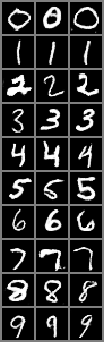

epoch: 8/10, batch: 10/600, G_loss: 1.864320993423462, D_loss: (0.6194336414337158, 0.2586786150932312)
epoch: 8/10, batch: 20/600, G_loss: 0.9537017941474915, D_loss: (0.07676120847463608, 0.6670275330543518)
epoch: 8/10, batch: 30/600, G_loss: 2.163464069366455, D_loss: (1.4470188617706299, 0.17575344443321228)
epoch: 8/10, batch: 40/600, G_loss: 1.6909316778182983, D_loss: (0.3182222247123718, 0.29352471232414246)
epoch: 8/10, batch: 50/600, G_loss: 0.31558912992477417, D_loss: (0.07678229361772537, 1.857284665107727)
epoch: 8/10, batch: 60/600, G_loss: 0.9340627789497375, D_loss: (0.15281808376312256, 0.7852433919906616)
epoch: 8/10, batch: 70/600, G_loss: 2.4007880687713623, D_loss: (0.7240374684333801, 0.1539911925792694)
epoch: 8/10, batch: 80/600, G_loss: 1.7725802659988403, D_loss: (0.5407565236091614, 0.2688380181789398)
epoch: 8/10, batch: 90/600, G_loss: 0.7255869507789612, D_loss: (0.18629631400108337, 0.8736255168914795)
epoch: 8/10, batch: 100/600, G_loss: 1.557020306587

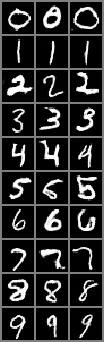

epoch: 8/10, batch: 210/600, G_loss: 0.9997355937957764, D_loss: (0.16934190690517426, 0.6677842736244202)
epoch: 8/10, batch: 220/600, G_loss: 1.3058439493179321, D_loss: (0.17310978472232819, 0.4419978857040405)
epoch: 8/10, batch: 230/600, G_loss: 1.7689299583435059, D_loss: (0.17819049954414368, 0.30376532673835754)
epoch: 8/10, batch: 240/600, G_loss: 0.8937609195709229, D_loss: (0.2320564091205597, 0.925831139087677)
epoch: 8/10, batch: 250/600, G_loss: 1.2200053930282593, D_loss: (0.3636186718940735, 0.49219000339508057)
epoch: 8/10, batch: 260/600, G_loss: 1.1929517984390259, D_loss: (0.42051833868026733, 0.47322794795036316)
epoch: 8/10, batch: 270/600, G_loss: 2.0057029724121094, D_loss: (0.4253197908401489, 0.20678718388080597)
epoch: 8/10, batch: 280/600, G_loss: 1.9518589973449707, D_loss: (0.45825695991516113, 0.28628379106521606)
epoch: 8/10, batch: 290/600, G_loss: 1.6683197021484375, D_loss: (0.6419837474822998, 0.3262585401535034)
epoch: 8/10, batch: 300/600, G_loss: 

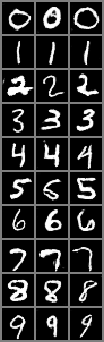

epoch: 8/10, batch: 410/600, G_loss: 1.6064530611038208, D_loss: (0.31065741181373596, 0.3166917860507965)
epoch: 8/10, batch: 420/600, G_loss: 0.817172110080719, D_loss: (0.14533989131450653, 0.8258970379829407)
epoch: 8/10, batch: 430/600, G_loss: 1.246490240097046, D_loss: (0.08494984358549118, 0.4827103912830353)
epoch: 8/10, batch: 440/600, G_loss: 2.2565462589263916, D_loss: (0.7953543066978455, 0.16717714071273804)
epoch: 8/10, batch: 450/600, G_loss: 0.9976807236671448, D_loss: (0.28428053855895996, 0.6316478252410889)
epoch: 8/10, batch: 460/600, G_loss: 3.323521614074707, D_loss: (1.4739468097686768, 0.054534703493118286)
epoch: 8/10, batch: 470/600, G_loss: 1.803035020828247, D_loss: (0.7659149169921875, 0.2509377598762512)
epoch: 8/10, batch: 480/600, G_loss: 1.7777708768844604, D_loss: (0.31430166959762573, 0.26738598942756653)
epoch: 8/10, batch: 490/600, G_loss: 2.9897079467773438, D_loss: (0.6307252645492554, 0.07875819504261017)
epoch: 8/10, batch: 500/600, G_loss: 2.0

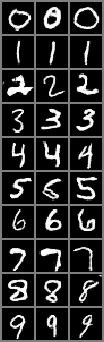

epoch: 9/10, batch: 10/600, G_loss: 2.486253261566162, D_loss: (0.49583888053894043, 0.138283833861351)
epoch: 9/10, batch: 20/600, G_loss: 1.5619674921035767, D_loss: (0.11844439804553986, 0.34703361988067627)
epoch: 9/10, batch: 30/600, G_loss: 0.8103803396224976, D_loss: (0.1591017246246338, 0.8346861004829407)
epoch: 9/10, batch: 40/600, G_loss: 3.5192925930023193, D_loss: (0.9183973670005798, 0.04025914520025253)
epoch: 9/10, batch: 50/600, G_loss: 1.6849169731140137, D_loss: (0.2387610375881195, 0.35815751552581787)
epoch: 9/10, batch: 60/600, G_loss: 1.2198349237442017, D_loss: (0.09757943451404572, 0.53537917137146)
epoch: 9/10, batch: 70/600, G_loss: 1.4071961641311646, D_loss: (0.17969703674316406, 0.434349924325943)
epoch: 9/10, batch: 80/600, G_loss: 2.3861544132232666, D_loss: (0.5552689433097839, 0.13989192247390747)
epoch: 9/10, batch: 90/600, G_loss: 2.809063673019409, D_loss: (0.6727262735366821, 0.08921577781438828)
epoch: 9/10, batch: 100/600, G_loss: 2.0192916393280

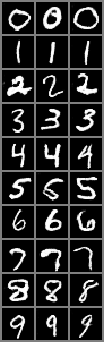

epoch: 9/10, batch: 210/600, G_loss: 1.9685606956481934, D_loss: (0.5022932887077332, 0.22125552594661713)
epoch: 9/10, batch: 220/600, G_loss: 0.9939091205596924, D_loss: (0.24888662993907928, 0.590579628944397)
epoch: 9/10, batch: 230/600, G_loss: 1.4867053031921387, D_loss: (0.14965134859085083, 0.3857586681842804)
epoch: 9/10, batch: 240/600, G_loss: 1.8279565572738647, D_loss: (0.26330044865608215, 0.2507704496383667)
epoch: 9/10, batch: 250/600, G_loss: 1.6001113653182983, D_loss: (0.22833219170570374, 0.3180657625198364)
epoch: 9/10, batch: 260/600, G_loss: 0.8993905782699585, D_loss: (0.11036120355129242, 0.7696102261543274)
epoch: 9/10, batch: 270/600, G_loss: 1.8898829221725464, D_loss: (0.6719629168510437, 0.2703167796134949)
epoch: 9/10, batch: 280/600, G_loss: 0.9714208841323853, D_loss: (0.16854892671108246, 0.7400750517845154)
epoch: 9/10, batch: 290/600, G_loss: 0.5016950368881226, D_loss: (0.04569990932941437, 1.2489458322525024)
epoch: 9/10, batch: 300/600, G_loss: 0.

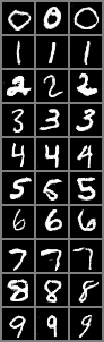

epoch: 9/10, batch: 410/600, G_loss: 0.9423866271972656, D_loss: (0.24184173345565796, 0.7193666100502014)
epoch: 9/10, batch: 420/600, G_loss: 2.212343692779541, D_loss: (0.19750471413135529, 0.17184406518936157)
epoch: 9/10, batch: 430/600, G_loss: 2.0636863708496094, D_loss: (0.43652093410491943, 0.24663513898849487)
epoch: 9/10, batch: 440/600, G_loss: 2.9785540103912354, D_loss: (0.8523507118225098, 0.08597681671380997)
epoch: 9/10, batch: 450/600, G_loss: 1.39606511592865, D_loss: (0.19588887691497803, 0.4255143404006958)
epoch: 9/10, batch: 460/600, G_loss: 1.61734938621521, D_loss: (0.2573149800300598, 0.3178786337375641)
epoch: 9/10, batch: 470/600, G_loss: 0.8318610191345215, D_loss: (0.24428442120552063, 0.8122636675834656)
epoch: 9/10, batch: 480/600, G_loss: 0.4329947233200073, D_loss: (0.04600023850798607, 1.3860292434692383)
epoch: 9/10, batch: 490/600, G_loss: 2.412339448928833, D_loss: (0.28921690583229065, 0.14536012709140778)
epoch: 9/10, batch: 500/600, G_loss: 2.26

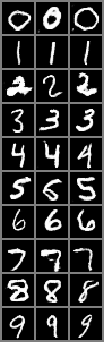

epoch: 10/10, batch: 10/600, G_loss: 1.530154824256897, D_loss: (0.14779092371463776, 0.3276127278804779)
epoch: 10/10, batch: 20/600, G_loss: 0.4242939352989197, D_loss: (0.04865473136305809, 1.344833254814148)
epoch: 10/10, batch: 30/600, G_loss: 1.0857385396957397, D_loss: (0.31812533736228943, 0.6097997426986694)
epoch: 10/10, batch: 40/600, G_loss: 1.7793676853179932, D_loss: (0.666332483291626, 0.31180447340011597)
epoch: 10/10, batch: 50/600, G_loss: 0.9893609881401062, D_loss: (0.33489853143692017, 0.6570442318916321)
epoch: 10/10, batch: 60/600, G_loss: 2.8740134239196777, D_loss: (0.8449647426605225, 0.08140488713979721)
epoch: 10/10, batch: 70/600, G_loss: 1.0177831649780273, D_loss: (0.1026470884680748, 0.6949508190155029)
epoch: 10/10, batch: 80/600, G_loss: 1.4518213272094727, D_loss: (0.13168777525424957, 0.4095618426799774)
epoch: 10/10, batch: 90/600, G_loss: 2.767897367477417, D_loss: (0.6142564415931702, 0.10661938041448593)
epoch: 10/10, batch: 100/600, G_loss: 2.39

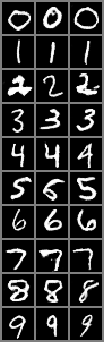

epoch: 10/10, batch: 210/600, G_loss: 1.2827239036560059, D_loss: (0.11240697652101517, 0.5056363940238953)
epoch: 10/10, batch: 220/600, G_loss: 2.213317632675171, D_loss: (0.7502579689025879, 0.1983407437801361)
epoch: 10/10, batch: 230/600, G_loss: 2.039968967437744, D_loss: (0.17951034009456635, 0.2076641321182251)
epoch: 10/10, batch: 240/600, G_loss: 2.1985602378845215, D_loss: (0.780016303062439, 0.18651758134365082)
epoch: 10/10, batch: 250/600, G_loss: 0.6875398755073547, D_loss: (0.1455608457326889, 1.0022037029266357)
epoch: 10/10, batch: 260/600, G_loss: 3.512288808822632, D_loss: (1.0567489862442017, 0.044000741094350815)
epoch: 10/10, batch: 270/600, G_loss: 1.4377644062042236, D_loss: (0.30749884247779846, 0.4063507318496704)
epoch: 10/10, batch: 280/600, G_loss: 1.1273036003112793, D_loss: (0.2763024568557739, 0.6099188923835754)
epoch: 10/10, batch: 290/600, G_loss: 0.8348634839057922, D_loss: (0.05789841338992119, 0.80567467212677)
epoch: 10/10, batch: 300/600, G_loss

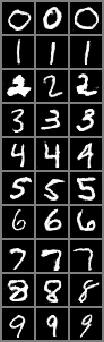

epoch: 10/10, batch: 410/600, G_loss: 1.5028197765350342, D_loss: (0.13996782898902893, 0.3733271062374115)
epoch: 10/10, batch: 420/600, G_loss: 2.041926860809326, D_loss: (0.11970437318086624, 0.23051396012306213)
epoch: 10/10, batch: 430/600, G_loss: 3.494649887084961, D_loss: (0.576459527015686, 0.05555372312664986)
epoch: 10/10, batch: 440/600, G_loss: 0.838904619216919, D_loss: (0.04597873613238335, 0.7941219210624695)
epoch: 10/10, batch: 450/600, G_loss: 2.279356002807617, D_loss: (0.656964898109436, 0.17627987265586853)
epoch: 10/10, batch: 460/600, G_loss: 1.1725802421569824, D_loss: (0.1907651722431183, 0.5317502021789551)
epoch: 10/10, batch: 470/600, G_loss: 1.3553259372711182, D_loss: (0.08335188031196594, 0.41559261083602905)
epoch: 10/10, batch: 480/600, G_loss: 3.863818645477295, D_loss: (0.8283408880233765, 0.0327223539352417)
epoch: 10/10, batch: 490/600, G_loss: 3.342071294784546, D_loss: (0.7842627167701721, 0.059012629091739655)
epoch: 10/10, batch: 500/600, G_los

In [55]:
for epoch in range(num_epochs + 1):
  
    # Train epoch
    for n_batch, (real_samples,real_labels) in enumerate(data_loader):
        one_hot_labels= torch.FloatTensor(batch_size, 10).zero_()
        one_hot_labels.scatter_(1, real_labels.view(batch_size,1), 1)
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        one_hot_labels = Variable(one_hot_labels).cuda()
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, one_hot_labels)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 200 == 0:
            val_fake_samples,_ = model.generate_samples(num_val_samples,  z=z_val, one_hot_labels=labels_val)
            val_fake_samples= val_fake_samples.data.cpu()
            display_batch_images(val_fake_samples, nrows=3)


Generated numbers:  0


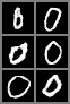

Generated numbers:  1


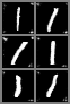

Generated numbers:  2


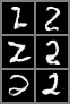

Generated numbers:  3


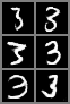

Generated numbers:  4


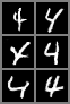

Generated numbers:  5


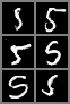

Generated numbers:  6


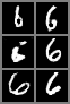

Generated numbers:  7


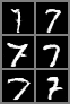

Generated numbers:  8


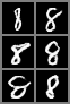

Generated numbers:  9


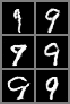

In [56]:
num_test_samples = 6
z_test = norm_noise(num_test_samples).cuda()

for i in range(0, 10):
  one_hot_labels_test= torch.FloatTensor(num_test_samples, 10).zero_()
  val_label= torch.ones(num_test_samples, dtype=torch.int64) * i
  one_hot_labels_test.scatter_(1, val_label.view(num_test_samples,1), 1)
  test_image, _= model.generate_samples(num_test_samples,  z=z_test, one_hot_labels=one_hot_labels_test.cuda())
  print('Generated numbers: ', i)
  display_batch_images(test_image.detach().cpu())


## Bibliography/Inspiration
Plot MNIST:
*   https://nextjournal.com/gkoehler/pytorch-mnist


Split train in train and validation: 
*   https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123


Encoder and decoder: 
*   https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
*   https://github.com/ShashiChilukuri/Deep-Learning-Projects/blob/master/CNN(PyTorch)%20-%20MNIST%20Convolutional%20Autoencoder/CNN(PyTorch)%20-%20MNIST%20Transpose%20Convolutional%20Autoencoder.ipynb


train_epoch and test_epoch:
*   DLAI lab04